In [1]:
# Author: Riley Owens (GitHub: mrileyowens)

# This file analyzes VLT spectra of the 
# Sunburst Arc to compare emission / absorption
# features to the star formation rate.

In [2]:
import os

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
#import astropy.units as u

from scipy.interpolate import interp1d

In [3]:
def c(w, tau):
    
    if str(tau) == '2':
        return 1e-46 * w
    
    elif str(tau) == '10':
        return 4.3e-47 * w
    
    else:
        print('Error: invalid value for tau')
        
def plaw(w, a, beta):
    return a*(w**beta)

def ew(w, f, cnorm, c, ferr, normerr):
    
    '''
    
    Inputs:
        w: wavelength
        f: flux density
        cnorm: normalized continuum fit
        c: unnormalized continuum fit
        ferr: flux density error
        normerr: normalization error
        
    Output:
        e: equivalent width
        err: equivalent width error
        
    '''
    
    e = (-1.0) * np.trapz(1.0 - (f / cnorm), w)
    
    err = np.sqrt(np.sum(np.square(ferr) + np.square(c * normerr)))

    return e, err

def bootstrap(w, f, c, ranges):
    
    wT = np.array([])
    fT = np.array([])
    cT = np.array([])
    
    # For each rest wavelength range of clean continuum
    for i, r in enumerate(ranges):
        
        # Trim wavelength, flux density, and 
        # continuum fit to bins of one segment 
        # of clean continuum
        wr = w[(w >= r[0]) & (w <= r[1])]
        fr = f[(w >= r[0]) & (w <= r[1])]
        cr = c[(w >= r[0]) & (w <= r[1])]
        
        # Add segment to array of all seg
        wT = np.append(wT, wr)
        fT = np.append(fT, fr)
        cT = np.append(cT, cr)
    
    NArr=np.array([])
    
    n = 0
    
    # Bootsrap error in normalization constant
    while n != 1000:
        
        # Pick indices of 10% of clean continuum to normalize the continuum fit against
        ind = np.random.choice(np.arange(0, len(wT), 1), int(round(0.1 * len(wT))), replace=False)
        
        # Flux density and continuum fit at selected indices
        #wi = np.take(wT, ind)
        fi = np.take(fT, ind)
        ci = np.take(cT, ind)
        
        # Mean of the normalization constants
        N = np.mean(fi / ci)
        
        NArr = np.append(NArr, N)
        
        n = n + 1
    
    return NArr
    

In [4]:
# Setting current path
path = os.getcwd()

# Setting directory for saved figures
figs = path + '/figs'

# Setting filepaths to data
dcFile = path + '/Region Images/PSZ311_CUBE_wcscorr.fits'
maskFile = path + '/Region Images/psz1550_1909_v2_mask.fits'
rcFile = path + '/VLT Reddening Corrections/h1RedCorrMUSE.fits'

In [5]:
# Setting plot labels
wlabel = 'Wavelength (Å)'
flabel17 = 'Flux Density (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)'
flabel20 = 'Flux Density (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)'

In [6]:
# Names and rest wavelengths of features to analyze
names = ['HeII 1640','OIII] 1661/6', 'CIII] 1907/9']
lines = [1640.4, 1663.5, 1908.0]

In [7]:
# Array of rest wavelength ranges free from strong features
ranges=np.array([[1345.0, 1370.0], [1415.0, 1435.0],
                 [1505.0, 1520.0], [1565.0, 1605.0], 
                 [1615.0, 1635.0], [1645.0, 1654.0], 
                 [1675.0, 1705.0], [1725.0, 1735.0], 
                 [1755.0, 1805.0], [1820.0, 1850.0], 
                 [1970.0, 2020.0], [2075.0, 2145.0]])

In [8]:
# Opening HDUs
dchdu = fits.open(dcFile)
maskhdu = fits.open(maskFile)
rchdu = fits.open(rcFile)

# Opening data arrays from HDUs
dc = dchdu[1].data
dcs = dchdu['STAT'].data
mask = maskhdu[0].data
rc = rchdu[1].data

#print(dchdu)
#print(dchdu[1].header['ERRDATA'])
#print(dchdu[1])
#print(dchdu['DATA'])
#print(dchdu['STAT'].data)

In [9]:
# Retrieving wavelength and Milky Way reddening values
w = rc['Wavelength (A)']
r = rc['Reddening Correction']

In [10]:
# Pixel angular width in radians
a1 = (dchdu[1].header['CD2_2'])*np.pi/180.0
a2 = (dchdu[1].header['CD2_2'])*np.pi/180.0

# Initiating cosmological model instance
cosmo = FlatLambdaCDM(70.0, 0.3)

# Angular diameter distance in Mpc
dA = cosmo.angular_diameter_distance(2.37)

# Luminosity distance in cm
dL = cosmo.luminosity_distance(2.37) * 3.086e24

# Computing area in square kpc of pixel in galaxy's
# rest frame
area = (dA*a1)*(dA*a2) * 1e6

In [11]:
# Wavelength array of VLT data trimmed to match range covered by reddening data
wVLT = np.arange(dchdu[1].header['NAXIS3'])*dchdu[1].header['CD3_3']+dchdu[1].header['CRVAL3']
wVLT = wVLT[wVLT <= np.max(w)]

# Trimming datacube to match same wavelength range
dc = dc[:len(wVLT),:,:]
dcs = dcs[:len(wVLT),:,:]

In [12]:
# Adjusting mask values to binary
mask[mask > 0] = 1.0
mask[mask <= 0] = 0.0

# Finding unmasked indices
indices = np.argwhere(mask[:,:] == 1.0)

In [13]:
# Broadcasting 2D arc mask to 3D datacube's shape
mask = np.broadcast_to(mask, dc.shape)

# Applying 3D mask onto datacube
dc = dc * mask
dcs = dcs * mask

[[1.08912058e-18 1.09141957e-18 7.28245930e-19]
 [1.02971178e-18 1.06480696e-18 9.42969706e-19]
 [9.38661642e-19 8.93956102e-19 7.63795705e-19]
 ...
 [1.31112022e-18 1.28349981e-18 7.41472892e-19]
 [1.11969054e-18 1.17894928e-18 1.01472954e-18]
 [1.23397611e-18 1.33853943e-18 9.82462414e-19]]


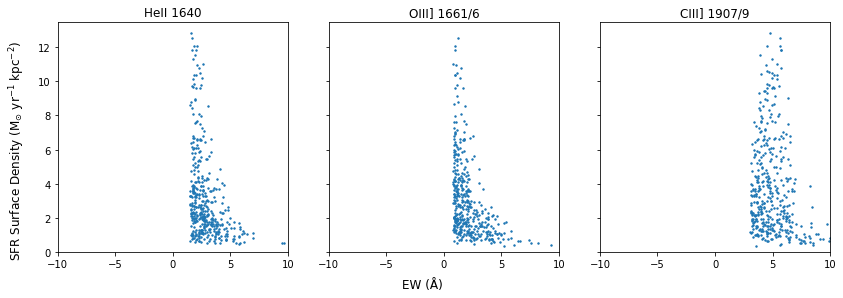

In [14]:
sfrsdArr = np.array([])
ewArr = np.empty((len(indices), len(lines)))
ewErrArr = np.empty((len(indices), len(lines)))

# For each unmasked pixel
for idx, index in enumerate(indices):
    
    # Flux density of unmasked pixel in erg/s/cm^2/A
    f = dc[:, index[0], index[1]] * 1e-20
    ferr = np.sqrt(dcs[:, index[0], index[1]]) * 1e-20
    
    # Applying Milky Way dereddening to flux density
    f = f * r
    ferr = ferr * r
    
    # Plot moving frame spectrum
    if False:
    
        plt.close('all')
    
        fig, ax = plt.subplots()
    
        ax.plot(w, f, lw=0.5, c='black')
    
        ax.set_xlim(np.min(wVLT), np.max(wVLT))
    
        ax.set_xlabel(wlabel)
        ax.set_ylabel(flabel)
    
        at = AnchoredText('X:'+str(index[0])+' Y:'+str(index[1]), loc='upper right', frameon=True)
        ax.add_artist(at)
        
        #plt.show()
        #fig.savefig(path+'/figs/vltspectra/vlt'+'X'+str(index[0])+'Y'+str(index[1])+'moving'+'.pdf')
        
    # Converting spectrum into rest frame
    w = wVLT / (1.0 + 2.37)
    f = f * (1.0 + 2.37)
    ferr = ferr * (1.0 + 2.37)
    
    # Continuum fit in erg/s/cm^2/Å
    #ct = plaw(w, 101040885.62610602, -2.132)*(np.median(f)/np.median(plaw(w, -2.132)))
    ct = plaw(w, 101040885.62610602, -2.132) * 1e-17
    
    normArr = bootstrap(w, f, ct, ranges)
    
    # Plot rest frame spectrum
    if False:
        
        plt.close('all')
        
        fig, ax = plt.subplots()
        
        ax.plot(w, f, lw=0.5, c='black')
        ax.axvline(1500.0, lw=0.5, ls='dashed', c='red')
        ax.plot(w, ct, lw=1.0, c='red')
        
        #ax.set_xlim(np.min(w), np.max(w))
        ax.set_xlim(np.min(w), np.max(w))
        
        ax.set_xlabel(wlabel)
        ax.set_ylabel(flabel)
        
        at = AnchoredText('X:'+str(index[0])+' Y:'+str(index[1]), loc='upper right', frameon=True)
        ax.add_artist(at)
        
        plt.show()
        #fig.savefig(path+'/figs/vltspectra/vlt'+'X'+str(index[0])+'Y'+str(index[1])+'rest'+'.pdf')
    
    i = interp1d(w, ct * np.mean(normArr))
    f1500 = i(1500.0)
    
    # Luminosity density (erg/s/)
    l1500 = 4.0*np.pi*f1500*(dL**2)
    
    l = l1500 * 1500.0 #/ area
    
    #print(l)
    
    sfr = l * c(1500.0, 2)
    sfrsd = sfr / area
    
    sfrsdArr = np.append(sfrsdArr, sfrsd)

    plt.close('all')

    fig, ax = plt.subplots(1, 3, sharey='row')

    for m, n in enumerate(lines):

        wmin = n * (1.0 + (-1000.0 / 3e5))
        wmax = n * (1.0 + (1000.0 / 3e5))

        fL = f[(w >= wmin) & (w <= wmax)]
        fLerr = ferr[(w >= wmin) & (w <= wmax)]
        ctL = ct[(w >= wmin) & (w <= wmax)]
        wL = w[(w >= wmin) & (w <= wmax)]

        eL, eLerr = ew(wL, fL, ctL * np.mean(normArr), ctL, fLerr, np.std(normArr))
        
        ewArr[idx, m] = eL
        ewErrArr[idx, m] = eLerr

        if False:
            
            plt.close('all')

            ax[m].plot(wN, fL, lw=0.5, c='black')
            ax[m].plot(wN, ctL, lw=0.5, c='red')

            ax[m].set_xlim(np.min(wL), np.max(wL))

            #ax[m].set_xlabel(wlabel)
            #ax[m].set_ylabel(flabel)

            at=AnchoredText('EW='+str(round(eN, 3)), loc='upper right', prop=dict(ha='right'), frameon=False)
            ax[m].add_artist(at)

            ax[m].set_box_aspect(1)

    fig.supxlabel(wlabel)
    fig.supylabel(flabel17)

    #plt.tight_layout()

    #plt.show()
        
plt.close('all')

fig, ax = plt.subplots(1, 3, sharey='row', figsize = (12,4))

print(ewErrArr)

for k, _ in enumerate(lines):
    
    eLArr = ewArr[:,k]
    eLErrArr = ewErrArr[:,k]
    sfrsdLArr = sfrsdArr[eLArr >= (np.mean(eLArr) + np.sqrt(np.sum(eLErrArr)))]
    eLArr =eLArr[eLArr >= (np.mean(eLArr) + np.sqrt(np.sum(eLErrArr)))]
    
    #ax[k].scatter(ewArr[:,k], sfrsdArr, s=2)
    ax[k].scatter(eLArr, sfrsdLArr, s=2)

    ax[k].set_xlim(-10.0, 10.0)
    ax[k].set_ylim(0.0)

    ax[k].set_title(names[k])

    ax[k].set_box_aspect(1)    

fig.supxlabel('EW (Å)')
fig.supylabel('SFR Surface Density (M$_{\odot}$ yr$^{-1}$ kpc$^{-2}$)')

fig.tight_layout()

fig.savefig(figs+'/sfrsd.pdf')

plt.show()